## CoNLL-2003 Example for Text Extensions for Pandas
### Part 4

To run this notebook, you will need to obtain a copy of the CoNLL-2003 data set's corpus.
Drop the corpus's files into the following locations:
* conll_03/eng.testa
* conll_03/eng.testb
* conll_03/eng.train

If you are unfamiliar with the basics of Text Extensions for Pandas, we recommend you 
start with Part 1 of this example.

### Introduction

At the end of part 3 of the demo, we've shown that we can train multiple synthetic models with different levels of deliberate imprecision. We used the ensemble of models to pinpoint incorrect labels in the validation set, using 
the same methods that we employed in [`CoNLL_2.ipynb`](./CoNLL_2.ipynb).

Now we need to pinpoint incorrect labels across the entire data set, including train, test, and validation sets.



# Libraries and constants

In [1]:
# The Jupyter kernel for this notebook usually starts up inside the notebooks
# directory, but the text_extensions_for_pandas package code is in the parent
# directory. Add that parent directory to the front of the Python include path.
import sys
if (sys.path[0] != ".."):
    sys.path[0] = ".."
    
# Libraries
import numpy as np
import pandas as pd
import os
import time
import torch
import transformers
from typing import *
import sklearn.model_selection
import sklearn.pipeline
import matplotlib.pyplot as plt

# And of course we need the text_extensions_for_pandas library itself.
import text_extensions_for_pandas as tp

# Common code shared across notebooks comes from util.py
import util

# BERT Configuration
# Keep this in sync with `CoNLL_3.ipynb`.
#bert_model_name = "bert-base-uncased"
#bert_model_name = "bert-large-uncased"
bert_model_name = "dslim/bert-base-NER"
tokenizer = transformers.BertTokenizerFast.from_pretrained(bert_model_name, 
                                                           add_special_tokens=True)
bert = transformers.BertModel.from_pretrained(bert_model_name)

# If False, use cached values, provided those values are present on disk
_REGENERATE_EMBEDDINGS = False
_REGENERATE_MODELS = False

# Number of dimensions that we reduce the BERT embeddings down to when
# training reduced-quality models.
#_REDUCED_DIMS = [8, 16, 32, 64, 128, 256]
_REDUCED_DIMS = [32, 64, 128, 256]

# How many models we train at each level of dimensionality reduction
_MODELS_AT_DIM = [4] * len(_REDUCED_DIMS)

# Consistent set of random seeds to use when generating dimension-reduced
# models. Index is [index into _REDUCED_DIMS, model number], and there are
# lots of extra entries so we don't need to resize this matrix.
from numpy.random import default_rng
_MASTER_SEED = 42
rng = default_rng(_MASTER_SEED)
_MODEL_RANDOM_SEEDS = rng.integers(0, 1e6, size=(8, 8))

# Create a Pandas categorical type for consistent encoding of categories
# across all documents.
_ENTITY_TYPES = ["LOC", "MISC", "ORG", "PER"]
token_class_dtype, int_to_label, label_to_int = tp.make_iob_tag_categories(_ENTITY_TYPES)

# Parameters for splitting the corpus into folds
_KFOLD_RANDOM_SEED = _MASTER_SEED
_KFOLD_NUM_FOLDS = 10


# Read inputs

Read in the corpus, retokenize it with the BERT tokenizer, add BERT embeddings, and convert
to a single dataframe.

In [2]:
# The raw dataset in its original tokenization
raw_data = {
    "validation": tp.conll_2003_to_dataframes("../conll_03/eng.testa"),
    "test": tp.conll_2003_to_dataframes("../conll_03/eng.testb"),
    "train": tp.conll_2003_to_dataframes("../conll_03/eng.train"),
}

In [3]:
# Retokenize with the BERT tokenizer

bert_data = {
    key: util.run_with_progress_bar(
        len(val), 
        lambda i: util.conll_to_bert(val[i], tokenizer, bert, token_class_dtype,
                                     compute_embeddings=_REGENERATE_EMBEDDINGS))
    for key, val in raw_data.items()
}

IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=231, style=ProgressStyle(desc…

IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=216, style=ProgressStyle(desc…

IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=946, style=ProgressStyle(desc…

In [4]:
# Create a single dataframe of annotated tokens for the entire corpus
if _REGENERATE_EMBEDDINGS:
    corpus_df = util.combine_folds(bert_data)
else:
    # Use embeddings computed in CoNLL_3.ipynb
    _EMBEDDINGS_FILE = "outputs/corpus.feather"
    if not os.path.exists(_EMBEDDINGS_FILE):
        raise ValueError(f"Precomputed embeddings not found at {_EMBEDDINGS_FILE}. "
                         f"Please rerun CoNLL_3.ipynb to regenerate this file, or "
                         f"set _REGENERATE_EMBEDDINGS to True in the previous cell.")
    corpus_df = pd.read_feather("outputs/corpus.feather")

corpus_df.head()

,fold,doc_num,token_id,ent_iob,ent_type,token_class,token_class_id,embedding
0,train,0,0,O,<NA>,O,0,[-9.85052735e-02 -4.05019164e-01 7.42888451e-0...
1,train,0,1,O,<NA>,O,0,[-5.70214391e-02 -4.81120974e-01 9.89868581e-0...
2,train,0,2,O,<NA>,O,0,[-4.82423156e-02 -2.53299564e-01 1.16719258e+0...
3,train,0,3,O,<NA>,O,0,[-2.66829729e-01 -3.10087800e-01 1.00747323e+0...
4,train,0,4,O,<NA>,O,0,[-0.22296865 -0.21308494 0.93310195 -0.2613592...


# Prepare folds for a 10-fold cross-validation

We divide the documents of the corpus into 10 random samples.

In [5]:
# IDs for each of the keys
doc_keys = corpus_df[["fold", "doc_num"]].drop_duplicates().reset_index(drop=True)
doc_keys

,fold,doc_num
0,train,0
1,train,1
2,train,2
3,train,3
4,train,4
...,...,...
1388,validation,226
1389,validation,227
1390,validation,228
1391,validation,229


In [6]:
# We want to split the documents randomly into _NUM_FOLDS sets, then
# for each stage of cross-validation train a model on the union of
# (_NUM_FOLDS - 1) of them while testing on the remaining fold.
# sklearn.model_selection doesn't implement this approach directly,
# but we can piece it together with some help from Numpy.
#from numpy.random import default_rng
rng = np.random.default_rng(seed=_KFOLD_RANDOM_SEED)
iloc_order = rng.permutation(len(doc_keys.index))
kf = sklearn.model_selection.KFold(n_splits=_KFOLD_NUM_FOLDS)

train_keys = []
test_keys = []
for train_ix, test_ix in kf.split(iloc_order):
    # sklearn.model_selection.KFold gives us a partitioning of the
    # numbers from 0 to len(iloc_order). Use that partitioning to 
    # choose elements from iloc_order, then use those elements to 
    # index into doc_keys.
    train_iloc = iloc_order[train_ix]
    test_iloc = iloc_order[test_ix]
    train_keys.append(doc_keys.iloc[train_iloc])
    test_keys.append(doc_keys.iloc[test_iloc])

train_keys[1].head(10)

,fold,doc_num
146,train,146
1164,validation,2
483,train,483
1190,validation,28
20,train,20
237,train,237
86,train,86
408,train,408
1252,validation,90
1213,validation,51


# Dry run: Train and evaluate models on the first fold

Train models on the first of our 10 folds and manually examine some of the 
model outputs.

In [7]:
# Gather the training set together by joining our list of documents
# with the entire corpus on the composite key <fold, doc_num>
train_inputs_df = corpus_df.merge(train_keys[0])
train_inputs_df

,fold,doc_num,token_id,ent_iob,ent_type,token_class,token_class_id,embedding
0,train,0,0,O,<NA>,O,0,[-9.85052735e-02 -4.05019164e-01 7.42888451e-0...
1,train,0,1,O,<NA>,O,0,[-5.70214391e-02 -4.81120974e-01 9.89868581e-0...
2,train,0,2,O,<NA>,O,0,[-4.82423156e-02 -2.53299564e-01 1.16719258e+0...
3,train,0,3,O,<NA>,O,0,[-2.66829729e-01 -3.10087800e-01 1.00747323e+0...
4,train,0,4,O,<NA>,O,0,[-0.22296865 -0.21308494 0.93310195 -0.2613592...
...,...,...,...,...,...,...,...,...
371472,validation,230,314,O,<NA>,O,0,[-2.81731989e-02 -8.06229934e-02 9.80488837e-0...
371473,validation,230,315,O,<NA>,O,0,[ 1.18173525e-01 -7.00841174e-02 8.65484536e-0...
371474,validation,230,316,B,PER,B-PER,4,[-3.56894195e-01 3.14004213e-01 1.57385373e+0...
371475,validation,230,317,O,<NA>,O,0,[-1.89571261e-01 -2.45811537e-01 6.62573814e-0...


In [8]:
# Repeat the same process for the test set
test_inputs_df = corpus_df.merge(test_keys[0])
test_inputs_df

,fold,doc_num,token_id,ent_iob,ent_type,token_class,token_class_id,embedding
0,train,12,0,O,<NA>,O,0,[-1.01978004e-01 -4.24425751e-01 8.44016969e-0...
1,train,12,1,O,<NA>,O,0,[-9.12464187e-02 -4.77107286e-01 1.12029290e+0...
2,train,12,2,O,<NA>,O,0,[-1.69527739e-01 -2.70634800e-01 1.20956659e+0...
3,train,12,3,O,<NA>,O,0,[-2.76481658e-01 -3.67584765e-01 1.09202504e+0...
4,train,12,4,O,<NA>,O,0,[-2.40506083e-01 -2.42475241e-01 1.07511532e+0...
...,...,...,...,...,...,...,...,...
45059,validation,225,75,O,<NA>,O,0,[-9.62142125e-02 -4.80168909e-01 5.10937929e-0...
45060,validation,225,76,O,<NA>,O,0,[-8.58625025e-02 -2.34172851e-01 8.32927167e-0...
45061,validation,225,77,O,<NA>,O,0,[-1.22388881e-02 -4.28266555e-01 6.19482934e-0...
45062,validation,225,78,O,<NA>,O,0,[-4.29561362e-02 -3.63153756e-01 6.60203218e-0...


## Train an ensemble of models

In [9]:
import importlib
util = importlib.reload(util)
import sklearn.linear_model

def train_models(train_df: pd.DataFrame) \
        -> Dict[str, sklearn.base.BaseEstimator]:
    """
    Train an ensemble of models with different levels of noise.
    
    :param train_df: DataFrame of labeled training documents, with one
     row per token. Must contain the columns "embedding" (precomputed 
     BERT embeddings) and "token_class_id" (integer ID of token type)
     
    :returns: A mapping from mnemonic model name to trained model
    """
    X = train_df["embedding"].values
    Y = train_df["token_class_id"]
    models = {}  # Type: Dict[str, sklearn.base.BaseEstimator]

    
    for i in range(len(_REDUCED_DIMS)):
        num_dims = _REDUCED_DIMS[i]
        num_models = _MODELS_AT_DIM[i]
        for j in range(num_models):
            model_name = f"{num_dims}_{j + 1}"
            seed = _MODEL_RANDOM_SEEDS[i, j]
            print(f"Training model '{model_name}' (#{j + 1} "
                  f"at {num_dims} dimensions) with seed {seed}")
            models[model_name] = util.train_reduced_model(X, Y, num_dims, seed)
    
    print(f"Training model using all of "
          f"{X._tensor.shape[1]}-dimension embeddings.")
    models[f"{X._tensor.shape[1]}_1"] = (
        sklearn.linear_model.LogisticRegression(
            multi_class="multinomial",
            verbose=10,
            max_iter=10000
        )
        .fit(X, Y)
    )
    return models

def maybe_train_models(train_df: pd.DataFrame, fold_num: int):
    import pickle
    _CACHED_MODELS_FILE = f"outputs/fold_{fold_num}_models.pickle"
    if _REGENERATE_MODELS or not os.path.exists(_CACHED_MODELS_FILE):
        m = train_models(train_df)
        print(f"Trained {len(m)} models.")
        with open(_CACHED_MODELS_FILE, "wb") as f:
            pickle.dump(m, f)
    else:
        # Use a cached model when using cached embeddings
        with open(_CACHED_MODELS_FILE, "rb") as f:
            m = pickle.load(f)
            print(f"Loaded {len(m)} models from {_CACHED_MODELS_FILE}.")
    return m

models = maybe_train_models(train_inputs_df, 0)
print(f"Model names after loading or training: {', '.join(models.keys())}")

Loaded 17 models from outputs/fold_0_models.pickle.
Model names after loading or training: 32_1, 32_2, 32_3, 32_4, 64_1, 64_2, 64_3, 64_4, 128_1, 128_2, 128_3, 128_4, 256_1, 256_2, 256_3, 256_4, 768_1


In [10]:
# Uncomment this code if you need to have the cells that follow ignore
# some of the models saved to disk.
# _MODEL_SIZES_TO_KEEP = [32, 64, 128, 256]
# _RUNS_TO_KEEP = [4] * len(_MODEL_SIZES_TO_KEEP)
# _OTHER_MODELS_TO_KEEP = ["768_1"]

# to_keep = _OTHER_MODELS_TO_KEEP.copy()
# for size in _MODEL_SIZES_TO_KEEP:
#     for num_runs in _RUNS_TO_KEEP:
#         for i in range(num_runs):
#             to_keep.append(f"{size}_{i+1}")

# models = {k: v for k, v in models.items() if k in to_keep}

# print(f"Model names after filtering: {', '.join(models.keys())}")

## Evaluate the models on this fold's test set

In [11]:
import importlib
util = importlib.reload(util)

def eval_models(models: Dict[str, sklearn.base.BaseEstimator],
                test_df: pd.DataFrame):
    """
    Bulk-evaluate an ensemble of models generated by :func:`train_models`.
    
    :param models: Output of :func:`train_models`
    :param test_df:  DataFrame of labeled test documents, with one
     row per token. Must contain the columns "embedding" (precomputed 
     BERT embeddings) and "token_class_id" (integer ID of token type)
    
    :returns: A dictionary from model name to results of 
     :func:`util.analyze_model`
    """
    todo = [(name, model) for name, model in models.items()]
    results = util.run_with_progress_bar(
        len(todo),
        lambda i: util.analyze_model(test_df, int_to_label, todo[i][1], 
                                     bert_data, raw_data, expand_matches=True),
        "model"
    )
    return {t[0]: result for t, result in zip(todo, results)}

evals = eval_models(models, test_inputs_df)

IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=17, style=ProgressStyle(descr…

In [12]:
# Summarize how each of the models does on the test set.
def make_summary_df(evals_df: pd.DataFrame) -> pd.DataFrame:
    global_scores = [r["global_scores"] for r in evals_df.values()]
    return pd.DataFrame({
        "name": list(evals_df.keys()),
        "dims": [n.split("_")[0] for n in evals_df.keys()],
        "num_true_positives": [r["num_true_positives"] for r in global_scores],
        "num_entities": [r["num_entities"] for r in global_scores],
        "num_extracted": [r["num_extracted"] for r in global_scores],
        "precision": [r["precision"] for r in global_scores],
        "recall": [r["recall"] for r in global_scores],
        "F1": [r["F1"] for r in global_scores]
    })

summary_df = make_summary_df(evals)

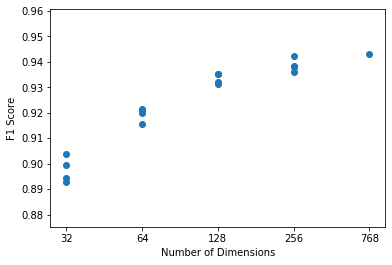

In [13]:
# Plot the tradeoff between dimensionality and F1 score
x = summary_df["dims"]
y = summary_df["F1"]
plt.scatter(x, y)
#plt.yscale("log")
#plt.xscale("log")
plt.xlabel("Number of Dimensions")
plt.ylabel("F1 Score")
plt.show()

## Aggregate the model results and compare with the gold standard

In [14]:
full_results = util.merge_model_results(evals)
full_results

IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=140, style=ProgressStyle(desc…

,doc_num,fold,doc_offset,token_span,ent_type,gold,32_1,32_2,32_3,32_4,...,128_1,128_2,128_3,128_4,256_1,256_2,256_3,256_4,768_1,num_models
0,0,train,12,"[11, 16): 'Saudi'",MISC,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,17
1,0,train,12,"[59, 65): 'MANAMA'",LOC,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,17
2,0,train,12,"[86, 91): 'Saudi'",MISC,True,True,True,False,False,...,True,True,True,True,True,True,True,True,True,14
3,0,train,12,"[259, 264): 'Saudi'",MISC,True,True,False,False,False,...,True,True,True,True,True,True,True,True,True,13
4,0,train,12,"[402, 411): 'One-month'",MISC,True,True,False,True,True,...,True,True,False,False,False,True,False,False,False,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,139,validation,225,"[11, 17): 'BOXING'",LOC,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,1
14,139,validation,225,"[86, 104): 'German Axel Schulz'",MISC,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,1
15,139,validation,225,"[45, 60): 'IBF HEAVYWEIGHT'",MISC,False,False,False,False,False,...,False,True,True,False,False,False,True,False,True,5
16,139,validation,225,"[19, 25): 'SCHULZ'",LOC,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,1


In [15]:
# Drop Boolean columns for now
results = full_results[["fold", "doc_offset", "token_span", "ent_type", "gold", "num_models"]]
results

,fold,doc_offset,token_span,ent_type,gold,num_models
0,train,12,"[11, 16): 'Saudi'",MISC,True,17
1,train,12,"[59, 65): 'MANAMA'",LOC,True,17
2,train,12,"[86, 91): 'Saudi'",MISC,True,14
3,train,12,"[259, 264): 'Saudi'",MISC,True,13
4,train,12,"[402, 411): 'One-month'",MISC,True,9
...,...,...,...,...,...,...
13,validation,225,"[11, 17): 'BOXING'",LOC,False,1
14,validation,225,"[86, 104): 'German Axel Schulz'",MISC,False,1
15,validation,225,"[45, 60): 'IBF HEAVYWEIGHT'",MISC,False,5
16,validation,225,"[19, 25): 'SCHULZ'",LOC,False,1


In [16]:
(results[results["gold"] == True][["num_models", "token_span"]]
 .groupby("num_models").count()
 .rename(columns={"token_span": "count"}))

,count
num_models,
0,115
1,31
2,23
3,20
4,17
5,18
6,23
7,23
8,19


In [17]:
(results[results["gold"] == False][["num_models", "token_span"]]
 .groupby("num_models").count()
 .rename(columns={"token_span": "count"}))

,count
num_models,
1,468
2,173
3,93
4,63
5,50
6,27
7,36
8,16
9,18


In [18]:
# Pull out some hard-to-find examples, sorting by document to make labeling easier
hard_to_get = results[results["gold"]].sort_values(["num_models", "fold", "doc_offset"]).head(20)
hard_to_get

,fold,doc_offset,token_span,ent_type,gold,num_models
0,test,21,"[25, 39): 'STANDARD LIEGE'",ORG,True,0
2,test,21,"[86, 90): 'UEFA'",ORG,True,0
18,test,64,"[2568, 2572): 'AIDS'",MISC,True,0
2,test,120,"[63, 70): 'English'",MISC,True,0
2,test,149,"[81, 93): 'Major League'",MISC,True,0
19,test,182,"[664, 672): 'division'",MISC,True,0
46,test,182,"[2173, 2177): 'Ruch'",ORG,True,0
6,test,203,"[881, 883): '90'",LOC,True,0
5,test,214,"[186, 201): 'Michael Collins'",MISC,True,0
7,test,214,"[283, 303): 'Venice Film Festival'",MISC,True,0


### TODO: Relabel the above 20 examples with a Markdown table (copy from CSV)


In [19]:
# Scratchpad for looking at individual docs
# fold = "test"
# doc_offset = 21

# first_model_name = list(evals.keys())[0]
# gold_standard_by_doc = evals[first_model_name]["actual_spans_by_doc"]
# doc_results = gold_standard_by_doc[(fold, doc_offset)]
# doc_results

In [20]:
# Part 2 of scratchpad
# doc_results["token_span"].values

In [21]:
# Hardest results not in the gold standard for models to avoid
hard_to_avoid = results[~results["gold"]].sort_values(["num_models", "fold", "doc_offset"], ascending=[False, True, True]).head(20)
hard_to_avoid

,fold,doc_offset,token_span,ent_type,gold,num_models
35,test,149,"[81, 102): 'Major League Baseball'",MISC,False,17
51,test,214,"[186, 201): 'Michael Collins'",PER,False,17
231,train,48,"[887, 901): 'Sjeng Schalken'",ORG,False,17
33,train,51,"[84, 105): 'Major League Baseball'",MISC,False,17
24,train,80,"[44, 59): 'rebels-Interfax'",ORG,False,17
40,train,130,"[25, 43): 'BELGIAN GRAND PRIX'",MISC,False,17
36,train,140,"[560, 574): 'Czech Republic'",LOC,False,17
35,train,263,"[81, 102): 'Major League Baseball'",MISC,False,17
18,train,283,"[862, 879): 'Florence Chitauro'",PER,False,17
207,train,436,"[3091, 3105): 'Flora Perfetti'",PER,False,17


### TODO: Relabel the above 20 examples (copy from CSV)


In [22]:
# Scratchpad for looking at individual docs
# fold = "test"
# doc_offset = 149

# first_model_name = list(evals.keys())[0]
# gold_standard_by_doc = evals[first_model_name]["actual_spans_by_doc"]
# doc_results = gold_standard_by_doc[(fold, doc_offset)]
# doc_results

In [23]:
# Part 2 of scratchpad
# doc_results["token_span"].values

# Remainder of Experiment

For each of the 10 folds, train a model on the fold's training set and run
analysis on the fold's test set.

In [24]:
def handle_fold(fold_ix: int) -> Dict[str, Any]:
    """
    The per-fold processing of the previous section's cells, collapsed into 
    a single function.
    
    :param fold_ix: 0-based index of fold
    
    :returns: a dictionary that maps data structure name to data structure
    """
    # To avoid accidentally picking up leftover data from a previous cell,
    # local to this function are named with a leading underscore
    _train_inputs_df = corpus_df.merge(train_keys[fold_ix])
    _test_inputs_df = corpus_df.merge(test_keys[fold_ix])
    _models = maybe_train_models(_train_inputs_df, fold_ix)
    _evals = eval_models(_models, _test_inputs_df)
    _summary_df = make_summary_df(_evals)
    _full_results = util.merge_model_results(_evals)
    _results = _full_results[["fold", "doc_offset", "token_span", 
                              "ent_type", "gold", "num_models"]]
    return {
        "models": _models,
        "summary_df": _summary_df,
        "full_results": _full_results,
        "results": _results
    }

# Start with the (already computed) results for fold 0
results_by_fold = [
    {
        "models": models,
        "summary_df": summary_df,
        "full_results": full_results,
        "results": results
    }
]

for fold in range(1, _KFOLD_NUM_FOLDS):
    print(f"Starting fold {fold}.")
    results_by_fold.append(handle_fold(fold))
    print(f"Done with fold {fold}.")
    

Starting fold 1.
Training model '32_1' (#1 at 32 dimensions) with seed 89250
Training model with n_components=32 and seed=89250.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min finished


Training model '32_2' (#2 at 32 dimensions) with seed 773956
Training model with n_components=32 and seed=773956.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min finished


Training model '32_3' (#3 at 32 dimensions) with seed 654571
Training model with n_components=32 and seed=654571.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min finished


Training model '32_4' (#4 at 32 dimensions) with seed 438878
Training model with n_components=32 and seed=438878.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min finished


Training model '64_1' (#1 at 64 dimensions) with seed 201469
Training model with n_components=64 and seed=201469.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.8min finished


Training model '64_2' (#2 at 64 dimensions) with seed 94177
Training model with n_components=64 and seed=94177.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.1min finished


Training model '64_3' (#3 at 64 dimensions) with seed 526478
Training model with n_components=64 and seed=526478.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min finished


Training model '64_4' (#4 at 64 dimensions) with seed 975622
Training model with n_components=64 and seed=975622.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min finished


Training model '128_1' (#1 at 128 dimensions) with seed 513226
Training model with n_components=128 and seed=513226.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.5min finished


Training model '128_2' (#2 at 128 dimensions) with seed 128113
Training model with n_components=128 and seed=128113.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.9min finished


Training model '128_3' (#3 at 128 dimensions) with seed 839748
Training model with n_components=128 and seed=839748.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.2min finished


Training model '128_4' (#4 at 128 dimensions) with seed 450385
Training model with n_components=128 and seed=450385.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.0min finished


Training model '256_1' (#1 at 256 dimensions) with seed 781567
Training model with n_components=256 and seed=781567.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 12.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 12.0min finished


Training model '256_2' (#2 at 256 dimensions) with seed 643865
Training model with n_components=256 and seed=643865.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 12.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 12.2min finished


Training model '256_3' (#3 at 256 dimensions) with seed 402414
Training model with n_components=256 and seed=402414.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 13.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 13.2min finished


Training model '256_4' (#4 at 256 dimensions) with seed 822761
Training model with n_components=256 and seed=822761.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 10.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 10.4min finished


Training model using all of 768-dimension embeddings.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 36.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 36.3min finished


Trained 17 models.


IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=17, style=ProgressStyle(descr…

IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=140, style=ProgressStyle(desc…

Done with fold 1.
Starting fold 2.
Training model '32_1' (#1 at 32 dimensions) with seed 89250
Training model with n_components=32 and seed=89250.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min finished


Training model '32_2' (#2 at 32 dimensions) with seed 773956
Training model with n_components=32 and seed=773956.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.5min finished


Training model '32_3' (#3 at 32 dimensions) with seed 654571
Training model with n_components=32 and seed=654571.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min finished


Training model '32_4' (#4 at 32 dimensions) with seed 438878
Training model with n_components=32 and seed=438878.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min finished


Training model '64_1' (#1 at 64 dimensions) with seed 201469
Training model with n_components=64 and seed=201469.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.8min finished


Training model '64_2' (#2 at 64 dimensions) with seed 94177
Training model with n_components=64 and seed=94177.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.1min finished


Training model '64_3' (#3 at 64 dimensions) with seed 526478
Training model with n_components=64 and seed=526478.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.0min finished


Training model '64_4' (#4 at 64 dimensions) with seed 975622
Training model with n_components=64 and seed=975622.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.3min finished


Training model '128_1' (#1 at 128 dimensions) with seed 513226
Training model with n_components=128 and seed=513226.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.5min finished


Training model '128_2' (#2 at 128 dimensions) with seed 128113
Training model with n_components=128 and seed=128113.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.3min finished


Training model '128_3' (#3 at 128 dimensions) with seed 839748
Training model with n_components=128 and seed=839748.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.9min finished


Training model '128_4' (#4 at 128 dimensions) with seed 450385
Training model with n_components=128 and seed=450385.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.2min finished


Training model '256_1' (#1 at 256 dimensions) with seed 781567
Training model with n_components=256 and seed=781567.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 10.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 10.8min finished


Training model '256_2' (#2 at 256 dimensions) with seed 643865
Training model with n_components=256 and seed=643865.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.2min finished


Training model '256_3' (#3 at 256 dimensions) with seed 402414
Training model with n_components=256 and seed=402414.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.7min finished


Training model '256_4' (#4 at 256 dimensions) with seed 822761
Training model with n_components=256 and seed=822761.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.9min finished


Training model using all of 768-dimension embeddings.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Trained 17 models.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 30.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 30.3min finished


IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=17, style=ProgressStyle(descr…

IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=140, style=ProgressStyle(desc…

Done with fold 2.
Starting fold 3.
Training model '32_1' (#1 at 32 dimensions) with seed 89250
Training model with n_components=32 and seed=89250.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min finished


Training model '32_2' (#2 at 32 dimensions) with seed 773956
Training model with n_components=32 and seed=773956.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min finished


Training model '32_3' (#3 at 32 dimensions) with seed 654571
Training model with n_components=32 and seed=654571.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min finished


Training model '32_4' (#4 at 32 dimensions) with seed 438878
Training model with n_components=32 and seed=438878.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min finished


Training model '64_1' (#1 at 64 dimensions) with seed 201469
Training model with n_components=64 and seed=201469.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min finished


Training model '64_2' (#2 at 64 dimensions) with seed 94177
Training model with n_components=64 and seed=94177.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.5min finished


Training model '64_3' (#3 at 64 dimensions) with seed 526478
Training model with n_components=64 and seed=526478.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.0min finished


Training model '64_4' (#4 at 64 dimensions) with seed 975622
Training model with n_components=64 and seed=975622.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.0min finished


Training model '128_1' (#1 at 128 dimensions) with seed 513226
Training model with n_components=128 and seed=513226.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.8min finished


Training model '128_2' (#2 at 128 dimensions) with seed 128113
Training model with n_components=128 and seed=128113.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.9min finished


Training model '128_3' (#3 at 128 dimensions) with seed 839748
Training model with n_components=128 and seed=839748.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.2min finished


Training model '128_4' (#4 at 128 dimensions) with seed 450385
Training model with n_components=128 and seed=450385.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.3min finished


Training model '256_1' (#1 at 256 dimensions) with seed 781567
Training model with n_components=256 and seed=781567.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.2min finished


Training model '256_2' (#2 at 256 dimensions) with seed 643865
Training model with n_components=256 and seed=643865.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.1min finished


Training model '256_3' (#3 at 256 dimensions) with seed 402414
Training model with n_components=256 and seed=402414.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.8min finished


Training model '256_4' (#4 at 256 dimensions) with seed 822761
Training model with n_components=256 and seed=822761.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.4min finished


Training model using all of 768-dimension embeddings.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Trained 17 models.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 26.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 26.4min finished


IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=17, style=ProgressStyle(descr…

IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=139, style=ProgressStyle(desc…

Done with fold 3.
Starting fold 4.
Training model '32_1' (#1 at 32 dimensions) with seed 89250
Training model with n_components=32 and seed=89250.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min finished


Training model '32_2' (#2 at 32 dimensions) with seed 773956
Training model with n_components=32 and seed=773956.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min finished


Training model '32_3' (#3 at 32 dimensions) with seed 654571
Training model with n_components=32 and seed=654571.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min finished


Training model '32_4' (#4 at 32 dimensions) with seed 438878
Training model with n_components=32 and seed=438878.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.6min finished


Training model '64_1' (#1 at 64 dimensions) with seed 201469
Training model with n_components=64 and seed=201469.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.0min finished


Training model '64_2' (#2 at 64 dimensions) with seed 94177
Training model with n_components=64 and seed=94177.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.7min finished


Training model '64_3' (#3 at 64 dimensions) with seed 526478
Training model with n_components=64 and seed=526478.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min finished


Training model '64_4' (#4 at 64 dimensions) with seed 975622
Training model with n_components=64 and seed=975622.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.8min finished


Training model '128_1' (#1 at 128 dimensions) with seed 513226
Training model with n_components=128 and seed=513226.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.2min finished


Training model '128_2' (#2 at 128 dimensions) with seed 128113
Training model with n_components=128 and seed=128113.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.2min finished


Training model '128_3' (#3 at 128 dimensions) with seed 839748
Training model with n_components=128 and seed=839748.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.3min finished


Training model '128_4' (#4 at 128 dimensions) with seed 450385
Training model with n_components=128 and seed=450385.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.2min finished


Training model '256_1' (#1 at 256 dimensions) with seed 781567
Training model with n_components=256 and seed=781567.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.0min finished


Training model '256_2' (#2 at 256 dimensions) with seed 643865
Training model with n_components=256 and seed=643865.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.9min finished


Training model '256_3' (#3 at 256 dimensions) with seed 402414
Training model with n_components=256 and seed=402414.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.4min finished


Training model '256_4' (#4 at 256 dimensions) with seed 822761
Training model with n_components=256 and seed=822761.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.4min finished


Training model using all of 768-dimension embeddings.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Trained 17 models.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 28.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 28.5min finished


IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=17, style=ProgressStyle(descr…

IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=139, style=ProgressStyle(desc…

Done with fold 4.
Starting fold 5.
Training model '32_1' (#1 at 32 dimensions) with seed 89250
Training model with n_components=32 and seed=89250.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.6min finished


Training model '32_2' (#2 at 32 dimensions) with seed 773956
Training model with n_components=32 and seed=773956.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min finished


Training model '32_3' (#3 at 32 dimensions) with seed 654571
Training model with n_components=32 and seed=654571.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min finished


Training model '32_4' (#4 at 32 dimensions) with seed 438878
Training model with n_components=32 and seed=438878.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min finished


Training model '64_1' (#1 at 64 dimensions) with seed 201469
Training model with n_components=64 and seed=201469.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min finished


Training model '64_2' (#2 at 64 dimensions) with seed 94177
Training model with n_components=64 and seed=94177.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.8min finished


Training model '64_3' (#3 at 64 dimensions) with seed 526478
Training model with n_components=64 and seed=526478.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.9min finished


Training model '64_4' (#4 at 64 dimensions) with seed 975622
Training model with n_components=64 and seed=975622.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min finished


Training model '128_1' (#1 at 128 dimensions) with seed 513226
Training model with n_components=128 and seed=513226.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.3min finished


Training model '128_2' (#2 at 128 dimensions) with seed 128113
Training model with n_components=128 and seed=128113.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.3min finished


Training model '128_3' (#3 at 128 dimensions) with seed 839748
Training model with n_components=128 and seed=839748.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.2min finished


Training model '128_4' (#4 at 128 dimensions) with seed 450385
Training model with n_components=128 and seed=450385.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.6min finished


Training model '256_1' (#1 at 256 dimensions) with seed 781567
Training model with n_components=256 and seed=781567.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.7min finished


Training model '256_2' (#2 at 256 dimensions) with seed 643865
Training model with n_components=256 and seed=643865.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.5min finished


Training model '256_3' (#3 at 256 dimensions) with seed 402414
Training model with n_components=256 and seed=402414.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.2min finished


Training model '256_4' (#4 at 256 dimensions) with seed 822761
Training model with n_components=256 and seed=822761.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.8min finished


Training model using all of 768-dimension embeddings.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Trained 17 models.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 26.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 26.0min finished


IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=17, style=ProgressStyle(descr…

IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=139, style=ProgressStyle(desc…

Done with fold 5.
Starting fold 6.
Training model '32_1' (#1 at 32 dimensions) with seed 89250
Training model with n_components=32 and seed=89250.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min finished


Training model '32_2' (#2 at 32 dimensions) with seed 773956
Training model with n_components=32 and seed=773956.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min finished


Training model '32_3' (#3 at 32 dimensions) with seed 654571
Training model with n_components=32 and seed=654571.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min finished


Training model '32_4' (#4 at 32 dimensions) with seed 438878
Training model with n_components=32 and seed=438878.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min finished


Training model '64_1' (#1 at 64 dimensions) with seed 201469
Training model with n_components=64 and seed=201469.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min finished


Training model '64_2' (#2 at 64 dimensions) with seed 94177
Training model with n_components=64 and seed=94177.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.7min finished


Training model '64_3' (#3 at 64 dimensions) with seed 526478
Training model with n_components=64 and seed=526478.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min finished


Training model '64_4' (#4 at 64 dimensions) with seed 975622
Training model with n_components=64 and seed=975622.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.0min finished


Training model '128_1' (#1 at 128 dimensions) with seed 513226
Training model with n_components=128 and seed=513226.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.3min finished


Training model '128_2' (#2 at 128 dimensions) with seed 128113
Training model with n_components=128 and seed=128113.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.9min finished


Training model '128_3' (#3 at 128 dimensions) with seed 839748
Training model with n_components=128 and seed=839748.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.5min finished


Training model '128_4' (#4 at 128 dimensions) with seed 450385
Training model with n_components=128 and seed=450385.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.4min finished


Training model '256_1' (#1 at 256 dimensions) with seed 781567
Training model with n_components=256 and seed=781567.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.3min finished


Training model '256_2' (#2 at 256 dimensions) with seed 643865
Training model with n_components=256 and seed=643865.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.5min finished


Training model '256_3' (#3 at 256 dimensions) with seed 402414
Training model with n_components=256 and seed=402414.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.6min finished


Training model '256_4' (#4 at 256 dimensions) with seed 822761
Training model with n_components=256 and seed=822761.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.6min finished


Training model using all of 768-dimension embeddings.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Trained 17 models.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 25.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 25.9min finished


IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=17, style=ProgressStyle(descr…

IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=139, style=ProgressStyle(desc…

Done with fold 6.
Starting fold 7.
Training model '32_1' (#1 at 32 dimensions) with seed 89250
Training model with n_components=32 and seed=89250.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min finished


Training model '32_2' (#2 at 32 dimensions) with seed 773956
Training model with n_components=32 and seed=773956.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min finished


Training model '32_3' (#3 at 32 dimensions) with seed 654571
Training model with n_components=32 and seed=654571.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min finished


Training model '32_4' (#4 at 32 dimensions) with seed 438878
Training model with n_components=32 and seed=438878.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min finished


Training model '64_1' (#1 at 64 dimensions) with seed 201469
Training model with n_components=64 and seed=201469.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min finished


Training model '64_2' (#2 at 64 dimensions) with seed 94177
Training model with n_components=64 and seed=94177.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min finished


Training model '64_3' (#3 at 64 dimensions) with seed 526478
Training model with n_components=64 and seed=526478.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.8min finished


Training model '64_4' (#4 at 64 dimensions) with seed 975622
Training model with n_components=64 and seed=975622.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.9min finished


Training model '128_1' (#1 at 128 dimensions) with seed 513226
Training model with n_components=128 and seed=513226.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.3min finished


Training model '128_2' (#2 at 128 dimensions) with seed 128113
Training model with n_components=128 and seed=128113.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.7min finished


Training model '128_3' (#3 at 128 dimensions) with seed 839748
Training model with n_components=128 and seed=839748.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.3min finished


Training model '128_4' (#4 at 128 dimensions) with seed 450385
Training model with n_components=128 and seed=450385.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.2min finished


Training model '256_1' (#1 at 256 dimensions) with seed 781567
Training model with n_components=256 and seed=781567.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.7min finished


Training model '256_2' (#2 at 256 dimensions) with seed 643865
Training model with n_components=256 and seed=643865.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.0min finished


Training model '256_3' (#3 at 256 dimensions) with seed 402414
Training model with n_components=256 and seed=402414.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.0min finished


Training model '256_4' (#4 at 256 dimensions) with seed 822761
Training model with n_components=256 and seed=822761.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.0min finished


Training model using all of 768-dimension embeddings.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Trained 17 models.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 27.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 27.0min finished


IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=17, style=ProgressStyle(descr…

IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=139, style=ProgressStyle(desc…

Done with fold 7.
Starting fold 8.
Training model '32_1' (#1 at 32 dimensions) with seed 89250
Training model with n_components=32 and seed=89250.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min finished


Training model '32_2' (#2 at 32 dimensions) with seed 773956
Training model with n_components=32 and seed=773956.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min finished


Training model '32_3' (#3 at 32 dimensions) with seed 654571
Training model with n_components=32 and seed=654571.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min finished


Training model '32_4' (#4 at 32 dimensions) with seed 438878
Training model with n_components=32 and seed=438878.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min finished


Training model '64_1' (#1 at 64 dimensions) with seed 201469
Training model with n_components=64 and seed=201469.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.0min finished


Training model '64_2' (#2 at 64 dimensions) with seed 94177
Training model with n_components=64 and seed=94177.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min finished


Training model '64_3' (#3 at 64 dimensions) with seed 526478
Training model with n_components=64 and seed=526478.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.0min finished


Training model '64_4' (#4 at 64 dimensions) with seed 975622
Training model with n_components=64 and seed=975622.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.2min finished


Training model '128_1' (#1 at 128 dimensions) with seed 513226
Training model with n_components=128 and seed=513226.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.1min finished


Training model '128_2' (#2 at 128 dimensions) with seed 128113
Training model with n_components=128 and seed=128113.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.8min finished


Training model '128_3' (#3 at 128 dimensions) with seed 839748
Training model with n_components=128 and seed=839748.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.1min finished


Training model '128_4' (#4 at 128 dimensions) with seed 450385
Training model with n_components=128 and seed=450385.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.4min finished


Training model '256_1' (#1 at 256 dimensions) with seed 781567
Training model with n_components=256 and seed=781567.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.3min finished


Training model '256_2' (#2 at 256 dimensions) with seed 643865
Training model with n_components=256 and seed=643865.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.4min finished


Training model '256_3' (#3 at 256 dimensions) with seed 402414
Training model with n_components=256 and seed=402414.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.1min finished


Training model '256_4' (#4 at 256 dimensions) with seed 822761
Training model with n_components=256 and seed=822761.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.0min finished


Training model using all of 768-dimension embeddings.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Trained 17 models.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 29.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 29.4min finished


IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=17, style=ProgressStyle(descr…

IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=139, style=ProgressStyle(desc…

Done with fold 8.
Starting fold 9.
Training model '32_1' (#1 at 32 dimensions) with seed 89250
Training model with n_components=32 and seed=89250.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min finished


Training model '32_2' (#2 at 32 dimensions) with seed 773956
Training model with n_components=32 and seed=773956.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.1min finished


Training model '32_3' (#3 at 32 dimensions) with seed 654571
Training model with n_components=32 and seed=654571.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min finished


Training model '32_4' (#4 at 32 dimensions) with seed 438878
Training model with n_components=32 and seed=438878.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min finished


Training model '64_1' (#1 at 64 dimensions) with seed 201469
Training model with n_components=64 and seed=201469.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min finished


Training model '64_2' (#2 at 64 dimensions) with seed 94177
Training model with n_components=64 and seed=94177.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.6min finished


Training model '64_3' (#3 at 64 dimensions) with seed 526478
Training model with n_components=64 and seed=526478.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min finished


Training model '64_4' (#4 at 64 dimensions) with seed 975622
Training model with n_components=64 and seed=975622.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.2min finished


Training model '128_1' (#1 at 128 dimensions) with seed 513226
Training model with n_components=128 and seed=513226.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.3min finished


Training model '128_2' (#2 at 128 dimensions) with seed 128113
Training model with n_components=128 and seed=128113.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.1min finished


Training model '128_3' (#3 at 128 dimensions) with seed 839748
Training model with n_components=128 and seed=839748.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.7min finished


Training model '128_4' (#4 at 128 dimensions) with seed 450385
Training model with n_components=128 and seed=450385.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.4min finished


Training model '256_1' (#1 at 256 dimensions) with seed 781567
Training model with n_components=256 and seed=781567.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.0min finished


Training model '256_2' (#2 at 256 dimensions) with seed 643865
Training model with n_components=256 and seed=643865.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.2min finished


Training model '256_3' (#3 at 256 dimensions) with seed 402414
Training model with n_components=256 and seed=402414.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.5min finished


Training model '256_4' (#4 at 256 dimensions) with seed 822761
Training model with n_components=256 and seed=822761.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.9min finished


Training model using all of 768-dimension embeddings.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Trained 17 models.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 26.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 26.1min finished


IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=17, style=ProgressStyle(descr…

IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=139, style=ProgressStyle(desc…

Done with fold 9.


In [25]:
# Combine all the results into a single dataframe for the entire corpus
all_results = pd.concat([r["results"] for r in results_by_fold])
all_results

,fold,doc_offset,token_span,ent_type,gold,num_models
0,train,12,"[11, 16): 'Saudi'",MISC,True,17
1,train,12,"[59, 65): 'MANAMA'",LOC,True,17
2,train,12,"[86, 91): 'Saudi'",MISC,True,14
3,train,12,"[259, 264): 'Saudi'",MISC,True,13
4,train,12,"[402, 411): 'One-month'",MISC,True,9
...,...,...,...,...,...,...
13,validation,216,"[20, 29): 'SHEFFIELD'",PER,False,12
14,validation,216,"[166, 174): 'Tasmania'",LOC,False,14
15,validation,216,"[179, 187): 'Victoria'",LOC,False,14
16,validation,216,"[20, 29): 'SHEFFIELD'",LOC,False,1


# Generate CSV files for manual labeling

In [27]:
# Reformat for output
test_and_validation_results = all_results[all_results["fold"].isin(["test", "validation"])]
in_gold_to_write, not_in_gold_to_write = util.csv_prep(test_and_validation_results, "num_models")
in_gold_to_write

,num_models,fold,doc_offset,corpus_span,corpus_ent_type,error_type,correct_span,correct_ent_type,notes,time_started,time_stopped,time_elapsed
0,0,test,0,"[20, 34): 'LEICESTERSHIRE'",ORG,,,,,,,
0,0,test,2,"[25, 30): 'ASHES'",MISC,,,,,,,
3,0,test,2,"[87, 92): 'Ashes'",MISC,,,,,,,
5,0,test,2,"[189, 218): 'Test and County Cricket Board'",ORG,,,,,,,
13,0,test,2,"[615, 636): 'Duke of Norfolk 's XI'",ORG,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...
21,17,validation,230,"[1108, 1115): 'Germany'",LOC,,,,,,,
23,17,validation,230,"[1153, 1160): 'England'",LOC,,,,,,,
24,17,validation,230,"[1213, 1225): 'Leeds United'",ORG,,,,,,,
25,17,validation,230,"[1252, 1259): 'England'",LOC,,,,,,,


In [28]:
not_in_gold_to_write

,num_models,fold,doc_offset,model_span,model_ent_type,error_type,corpus_span,corpus_ent_type,correct_span,correct_ent_type,notes,time_started,time_stopped,time_elapsed
51,17,test,2,"[762, 767): 'Leeds'",LOC,,,,,,,,,
19,17,test,6,"[262, 267): 'Rotor'",PER,,,,,,,,,
20,17,test,6,"[401, 406): 'Rotor'",PER,,,,,,,,,
21,17,test,6,"[570, 575): 'Rotor'",PER,,,,,,,,,
101,17,test,11,"[1971, 1985): 'Czech Republic'",LOC,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,1,validation,228,"[40, 43): 'SIX'",ORG,,,,,,,,,
44,1,validation,228,"[831, 845): 'Super Peasants'",MISC,,,,,,,,,
49,1,validation,228,"[802, 812): 'Doetinchem'",MISC,,,,,,,,,
28,1,validation,230,"[19, 29): 'ENGLISHMAN'",LOC,,,,,,,,,


In [29]:
in_gold_to_write.to_csv("outputs/CoNLL_4_in_gold.csv", index=False)
not_in_gold_to_write.to_csv("outputs/CoNLL_4_not_in_gold.csv", index=False)

In [30]:
# Repeat for the contents of the original training set
train_results = all_results[all_results["fold"] == "train"]
in_gold_to_write, not_in_gold_to_write = util.csv_prep(train_results, "num_models")
in_gold_to_write

,num_models,fold,doc_offset,corpus_span,corpus_ent_type,error_type,correct_span,correct_ent_type,notes,time_started,time_stopped,time_elapsed
3,0,train,6,"[121, 137): 'Toronto Dominion'",PER,,,,,,,
4,0,train,24,"[162, 170): 'Africans'",MISC,,,,,,,
7,0,train,24,"[386, 390): 'FLNC'",ORG,,,,,,,
4,0,train,25,"[141, 151): 'mid-Norway'",MISC,,,,,,,
13,0,train,28,"[1129, 1131): 'EU'",ORG,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...
2,17,train,945,"[72, 79): 'English'",MISC,,,,,,,
3,17,train,945,"[119, 127): 'Plymouth'",ORG,,,,,,,
4,17,train,945,"[130, 137): 'Preston'",ORG,,,,,,,
5,17,train,945,"[155, 162): 'Swansea'",ORG,,,,,,,


In [31]:
not_in_gold_to_write

,num_models,fold,doc_offset,model_span,model_ent_type,error_type,corpus_span,corpus_ent_type,correct_span,correct_ent_type,notes,time_started,time_stopped,time_elapsed
8,17,train,3,"[0, 10): '-DOCSTART-'",LOC,,,,,,,,,
13,17,train,6,"[121, 137): 'Toronto Dominion'",LOC,,,,,,,,,
10,17,train,25,"[141, 151): 'mid-Norway'",LOC,,,,,,,,,
66,17,train,29,"[456, 470): 'Phil Mickelson'",PER,,,,,,,,,
67,17,train,29,"[765, 777): 'Mark O'Meara'",PER,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42,1,train,943,"[25, 41): 'SAN MARINO GRAND'",LOC,,,,,,,,,
60,1,train,944,"[11, 15): 'GOLF'",LOC,,,,,,,,,
62,1,train,944,"[25, 32): 'MASTERS'",PER,,,,,,,,,
63,1,train,944,"[17, 32): 'BRITISH MASTERS'",LOC,,,,,,,,,


In [32]:
in_gold_to_write.to_csv("outputs/CoNLL_4_train_in_gold.csv", index=False)
not_in_gold_to_write.to_csv("outputs/CoNLL_4_train_not_in_gold.csv", index=False)